#**Trabajo Practico Nº1**
**Mariana Szewach - Amalia Oxandaberro - Camila Cirignoli**

***PARTE I***

Para la evaluación del TP se debe informar claramente:

1) Técnica de validación utilizada. La metodología con respecto a este punto debe ser impecable. \\
2) Elección de una métrica primaria \\
3) Informar las métricas secundarias: Precision, Recall, F1-Score y ROC-AUC, explicando claramente qué mide cada una de ellas, sus ventajas y desventajas. \\
4) Para las métricas mencionadas anteriormente realizar una interpretaciòn y comparación para el modelo NBMN y MLP. \\
5) En las conclusiones informar si el dataset posee o no sesgos en el armado de los datos.


#Librerías

En primer lugar, se cargan todas las librerias a utilizar en el siguiente trabajo

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
from termcolor import colored
from collections import Counter

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


#Cargar datos de Kaggle

Luego se prosigue cargando los datos desde kaggle

In [ ]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"amaliaoxandaberro","key":"dc3caded742346409c8426f0109c18a1"}'}

In [ ]:
!cp kaggle.json ~/.kaggle/
!kaggle competitions download -c sesgos-en-el-dataset-de-snli

train_data.hdf5.zip: Skipping, found more recently modified local copy (use --force to force download)
valid_data.hdf5.zip: Skipping, found more recently modified local copy (use --force to force download)
submission_sample.csv: Skipping, found more recently modified local copy (use --force to force download)
test_data.hdf5.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip test_data.hdf5.zip
!unzip train_data.hdf5.zip
!unzip valid_data.hdf5.zip

Archive:  test_data.hdf5.zip
replace test_data.hdf5? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test_data.hdf5          
Archive:  train_data.hdf5.zip
replace train_data.hdf5? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train_data.hdf5         
Archive:  valid_data.hdf5.zip
replace valid_data.hdf5? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: valid_data.hdf5         


In [ ]:
df_train = pd.read_hdf("/content/train_data.hdf5")
df_valid = pd.read_hdf("/content/valid_data.hdf5")
df_test = pd.read_hdf("/content/test_data.hdf5")

#Análisis de los datos

El dataset de SNLI consta de 569033 entradas con dos frases: premisas e hipótesis. A cada entrada se le asigna una etiqueta: entailment, contradiction o neutral. 

Dadas dos frases A y B, si B es implicación de A ("entailment"), B es contradictorio con A ("contradiction") o si lo que enuncia B es neutral respecto de A ("neutral"). Se dice que A es la premisa y B es la hipótesis. \\
En Gururangan et al., 2018 mostraron que este dataset tiene algunos sesgos, provocados por ejemplo por las heurísticas que tienen los humanos para generar estos pares de frases (A, B). Para ello, desarrollaron un modelo que aún sin observar la premisa A pudiera clasificar el par (A,B) en alguna de las clases del dataset. En este trabajo práctico intentaremos predecir a qué clase pertenece cada una de las hipótesis sin observar la premisa. La idea es replicar los resultados publicados en Gururangan et al., 2018 y mejorarlos si es posible utilizando clasificadores más complejos.


Se analiza tanto el formato como la estructura del dataset para comprender su composición y la distribución de los datos los cuales se encuentran divididos en las categorías entrenamiento, validación y prueba.

Se pasaron los datos a listas para poder utilizar luego el vectorizador Count Vectorizer.  

In [ ]:
text_train = df_train["text"].tolist()
labels_train = df_train["gold_label"].tolist()

text_valid = df_valid["text"].tolist()
labels_valid = df_valid["gold_label"].tolist()

text_test = df_test["text"].tolist()

A continuación se pueden visualizar el formato de los datos junto con las labels existentes. \\

Se observa que en los tres grupos hay palabras con mayúsculas, minúsculas y signos de puntuación, lo que es tenido en cuenta para el posterior preprocesamiento. 

In [ ]:
df_train.head()

,gold_label,text
pairID,,
1000092795.jpg#0r1c,contradiction,they are inside of a house
1000092795.jpg#0r1e,entailment,two guys are in a yard
1000092795.jpg#0r1n,neutral,They are doing yardwork
1000092795.jpg#1r1c,contradiction,A man is swimming.
1000092795.jpg#1r1e,entailment,Two young white men are near some bushes.


In [ ]:
df_valid.head()

,gold_label,text
pairID,,
100197432.jpg#4r1c,contradiction,The women are seated in a bistro eating lunch.
100197432.jpg#4r1e,entailment,There are muliple women outdoors.
100197432.jpg#4r1n,neutral,The women are friends.
1026792563.jpg#1r1c,contradiction,A group of women are fishing
1026792563.jpg#1r1e,entailment,A group of women are selling their wares


In [ ]:
df_test.head()

,text
pairID,
0,The church has cracks in the ceiling.
1,The church is filled with song.
2,A choir singing at a baseball game.
3,The woman is young.
4,The woman is very happy.


En los siguientes gráficos de tortas se pueden ver representadas las tres categorías existentes: contradiction, neutral e entailment con el objetivo de determinar si las clases se encuentran balanceadas tanto en train como en valid.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd73747b690>],
      dtype=object)

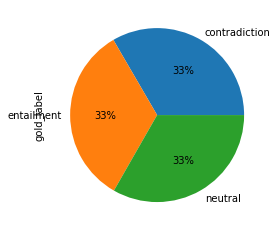

In [ ]:
df_train["gold_label"].value_counts().plot(kind='pie', labels=df_train["gold_label"], autopct='%1.0f%%', subplots=True, figsize=(4, 4))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd70aed6210>],
      dtype=object)

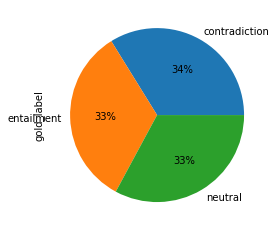

In [ ]:
df_valid["gold_label"].value_counts().plot(kind='pie', labels=df_train["gold_label"], autopct='%1.0f%%', subplots=True, figsize=(4, 4))

A continuación se observa la similitud en la cantidad de valores de cada categoría.

In [ ]:
Counter(labels_train)

Counter({'contradiction': 183187, 'entailment': 183416, 'neutral': 182764})

Se presentan la cantidad de datos para entrenamiento, validación y prueba con sus respectivos porcentajes 

In [ ]:
tot = len(text_train) + len(text_valid) + len(text_test)
train_p = (len(text_train)*100)/tot
valid_p = (len(text_valid)*100)/tot
test_p = (len(text_test)*100)/tot
print("Cantidad de datos para entrenamiento: " + str(len(text_train)) + " ("+ str(train_p) + "% de los datos totales)")
print("Cantidad de datos para validación: " + str(len(text_valid)) + " ("+ str(valid_p) + "% de los datos totales)")
print("Cantidad de datos para test: " + str(len(text_test)) + " ("+ str(test_p) + "% de los datos totales)")

Cantidad de datos para entrenamiento: 549367 (96.54396142227252% de los datos totales)
Cantidad de datos para validación: 9842 (1.7296009194545834% de los datos totales)
Cantidad de datos para test: 9824 (1.7264376582728946% de los datos totales)


#Modelo sencillo visto en clase

In [ ]:
cv = CountVectorizer(min_df=100, ngram_range = (1,2)) 


In [ ]:
cv_train = cv.fit_transform(text_train)
cv_valid = cv.transform(text_valid)

In [ ]:
clf = MultinomialNB(alpha=1e-10)
clf.fit(cv_train, labels_train)

MultinomialNB(alpha=1e-10, class_prior=None, fit_prior=True)

In [ ]:
print(clf.score(cv_train, labels_train))
print(clf.score(cv_valid, labels_valid))

0.6059646829896954
0.6143060353586669


#Modelo con preprocesamiento de texto

##Preprocesamiento de texto

###Preprocesadores

A continuación se prueban los siguientes preprocesadores de texto:

*   Procesamiento básico: pasaje a minúsculas, eliminación de stopwords y eliminación de signos de puntuación.
*   Procesamiento básico con stemming: pasaje a minúsculas, eliminación de stopwords, eliminación de signos de puntuación y conversión de palabras a su raiz (stemming).
*   Procesamiento básico con lemmatizer: pasaje a minúsculas, eliminación de stopwords, eliminación de signos de puntuación, unificación de género en las palabras y pasaje de verbos al infinitvo (lemmatizer).
*  Procesamiento con lemmatizer y atributo POS: el atributo POS corresponde a un proceso de etiquetado a cada palabra en una oración según su clase (sustantivo, adjetivo, verbo). En este procesador se tiene en cuenta este atributo junto con el item anterior. 
* Procesamiento con stemming, lemmatizer y atributo POS: este procesador engloba todas las características listadas anteriormente. 

In [ ]:
#lower, elimina stop words y signos de puntuación 
def p_basico(text):

  stoplist = set(nltk.corpus.stopwords.words('english') + list(punctuation)) 
  
  words =[token.lower() for token in nltk.word_tokenize(text) if (token.lower() not in stoplist) and token.isalpha()]

  return ' '.join(words) 

#procesador basico + stemer
def p_basico_Stem(text):
  
  # stem words
  stemmer = nltk.stem.PorterStemmer()

  stoplist = set(nltk.corpus.stopwords.words('english') + list(punctuation))
  
  words =[token.lower() for token in nltk.word_tokenize(text) if (token.lower() not in stoplist) and token.isalpha()]
  stemmed_words=[stemmer.stem(word=word) for word in words]

  return ' '.join(stemmed_words)


#procesador basico + lemmatizer
def p_basico_Lemma(text):
  
  # stem words
  lemmatizer = nltk.stem.WordNetLemmatizer()

  stoplist = set(nltk.corpus.stopwords.words('english') + list(punctuation))
  
  words =[token.lower() for token in nltk.word_tokenize(text) if (token.lower() not in stoplist) and token.isalpha()]
  lemma_words=[lemmatizer.lemmatize(word=word) for word in words]

  return ' '.join(lemma_words)


# agrega el atributo POS según el tag de la palabra
def nltk_tag_to_wordnet_tag(nltk_tag):
  if nltk_tag.startswith('J'):
      return nltk.corpus.wordnet.ADJ
  elif nltk_tag.startswith('V'):
      return nltk.corpus.wordnet.VERB
  elif nltk_tag.startswith('N'):
      return nltk.corpus.wordnet.NOUN
  elif nltk_tag.startswith('R'):
      return nltk.corpus.wordnet.ADV
  else:          
      return None

def p_Lemma_POS(sentence):

  lemmatizer = nltk.stem.WordNetLemmatizer()
  stoplist = set(nltk.corpus.stopwords.words('english') + list(punctuation))
  words =[token.lower() for token in nltk.word_tokenize(sentence) if (token.lower() not in stoplist) and token.isalpha()]
  nltk_tagged = nltk.pos_tag(words)  

  wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
  lemmatized_sentence = []
  for word, tag in wordnet_tagged:
      if tag is None:
          lemmatized_sentence.append(word)
      else:        
          lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
  return " ".join(lemmatized_sentence)


#procesador basico + lemmatizer con POS y stemming
def p_Lemma_POS_Stem(sentence):

  lemmatizer = nltk.stem.WordNetLemmatizer()
  stemmer = nltk.stem.PorterStemmer()

  stoplist = set(nltk.corpus.stopwords.words('english') + list(punctuation))
  words =[token.lower() for token in nltk.word_tokenize(sentence) if (token.lower() not in stoplist) and token.isalpha()]
  nltk_tagged = nltk.pos_tag(words)  

  wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
  stem_sentence = []
  for word, tag in wordnet_tagged:
      if tag is None:
          stem_sentence.append(stemmer.stem(word))
      else:        
          stem_sentence.append(stemmer.stem(lemmatizer.lemmatize(word, tag)))
  return " ".join(stem_sentence)



###Prueba de los preprocesadores

A continuación se prueban cada uno de los preprocesadores para comprobar su respectivo funcionamiento, utilizando los primeros 5 datos del set de train.


In [ ]:
df_train.head()

,gold_label,text
pairID,,
1000092795.jpg#0r1c,contradiction,they are inside of a house
1000092795.jpg#0r1e,entailment,two guys are in a yard
1000092795.jpg#0r1n,neutral,They are doing yardwork
1000092795.jpg#1r1c,contradiction,A man is swimming.
1000092795.jpg#1r1e,entailment,Two young white men are near some bushes.


In [ ]:
print(colored('Stop words, lower y puntuación', attrs=['bold', 'underline']))
for i in range(5):
  proc = p_basico(text_train[i])
  print(proc)

Stop words, lower y puntuación
inside house
two guys yard
yardwork
man swimming
two young white men near bushes


In [ ]:
print(colored('Stop words, lower y puntuación + Stemming', attrs=['bold', 'underline']))
for i in range(5):
  proc = p_basico_Stem(text_train[i])
  print(proc)

Stop words, lower y puntuación + Stemming
insid hous
two guy yard
yardwork
man swim
two young white men near bush


In [ ]:
print(colored('Stop words, lower y puntuación + Lemmatización', attrs=['bold', 'underline']))
for i in range(5):
  proc = p_basico_Lemma(text_train[i])
  print(proc)

Stop words, lower y puntuación + Lemmatización
inside house
two guy yard
yardwork
man swimming
two young white men near bush


In [ ]:
print(colored('Stop words, lower y puntuación + POS + Lemmatización', attrs=['bold', 'underline']))
for i in range(5):
  proc = p_Lemma_POS(text_train[i])
  print(proc)

Stop words, lower y puntuación + POS + Lemmatización
inside house
two guy yard
yardwork
man swim
two young white men near bush


In [ ]:
print(colored('Stop words, lower y puntuación + POS + Lemmatización + Stemming', attrs=['bold', 'underline']))
for i in range(5):
  proc = p_Lemma_POS_Stem(text_train[i])
  print(proc)

Stop words, lower y puntuación + POS + Lemmatización + Stemming
insid hous
two guy yard
yardwork
man swim
two young white men near bush


###Preprocesamiento

En esta sección se aplican todos los procesadores a las categorías de train y valid. 

In [ ]:
#Tarda mucho en correr
trainSW = []
trainStem = []
trainLemma = []
trainLemmaPOS = []
trainProc = []

largo = len(text_train)
for i in range(largo):
  trainSW.append(p_basico(text_train[i]))
  trainStem.append(p_basico_Stem(text_train[i]))
  trainLemma.append(p_basico_Lemma(text_train[i]))
  trainLemmaPOS.append(p_Lemma_POS(text_train[i]))
  trainProc.append(p_Lemma_POS_Stem(text_train[i]))


In [ ]:
validSW = []
validStem = []
validLemma = []
validLemmaPOS = []
validProc = []

largo = len(text_valid)
for i in range(largo):
  validSW.append(p_basico(text_valid[i]))
  validStem.append(p_basico_Stem(text_valid[i]))
  validLemma.append(p_basico_Lemma(text_valid[i]))
  validLemmaPOS.append(p_Lemma_POS(text_valid[i]))
  validProc.append(p_Lemma_POS_Stem(text_valid[i]))

##CountVectorizer

Una vez preprocesados los datos, se utiliza la función Count Vectorizer para generar los vectores que contienen la frecuencia de las palabras del vocabulario para cada una de las frases utilizadas. 

In [ ]:
vect1 = CountVectorizer(stop_words=None,lowercase=True,analyzer='word', max_df=0.60, min_df=10, ngram_range = (1,6))
vect2 = CountVectorizer(stop_words=None,lowercase=True,analyzer='word', max_df=0.6, min_df=10, ngram_range = (1,6))
vect3 = CountVectorizer(stop_words=None,lowercase=True,analyzer='word', max_df=0.6, min_df=10, ngram_range = (1,6))
vect4 = CountVectorizer(stop_words=None,lowercase=True,analyzer='word', max_df=0.6, min_df=10, ngram_range = (1,6))
vect5 = CountVectorizer(stop_words=None,lowercase=True,analyzer='word', max_df=0.6, min_df=10, ngram_range = (1,6))


In [ ]:
vect_trainSW = vect1.fit_transform(trainSW)
vect_trainStem = vect2.fit_transform(trainStem)
vect_trainLemma = vect3.fit_transform(trainLemma)
vect_trainLemmaPOS = vect4.fit_transform(trainLemmaPOS)
vect_trainProc = vect5.fit_transform(trainProc)

vect_valSW = vect1.transform(validSW)
vect_valStem = vect2.transform(validStem)
vect_valLemma = vect3.transform(validLemma)
vect_valLemmaPOS = vect4.transform(validLemmaPOS)
vect_valProc = vect5.transform(validProc)


En la siguiente celda, se crea un modelo clasificador denominado Multinomial Naive Bayes. Se trata de un clasificador probabilístico fundamentado en el teorema de Bayes. A su vez posee hipótesis simplificadoras como la independencia entre las variables predictoras.

In [ ]:
clfSW = MultinomialNB(alpha=1e-10)
clfSW.fit(vect_trainSW, labels_train)

clfStem = MultinomialNB(alpha=1e-10)
clfStem.fit(vect_trainStem, labels_train)

clfLemma = MultinomialNB(alpha=1e-10)
clfLemma.fit(vect_trainLemma, labels_train)

clfLemmaPOS = MultinomialNB(alpha=1e-10)
clfLemmaPOS.fit(vect_trainLemmaPOS, labels_train)

clfProc = MultinomialNB(alpha=1e-10)
clfProc.fit(vect_trainProc, labels_train)

MultinomialNB(alpha=1e-10, class_prior=None, fit_prior=True)

##Resultados

###Scores

In [ ]:
print(clfSW.score(vect_trainSW, labels_train))
print(clfStem.score(vect_trainStem, labels_train))
print(clfLemma.score(vect_trainLemma, labels_train))
print(clfLemmaPOS.score(vect_trainLemmaPOS, labels_train))
print(clfProc.score(vect_trainProc, labels_train))


0.6319072678191445
0.6319127286495184
0.6323168300971845
0.631481323049983
0.6309407008429702


In [ ]:
print(clfSW.score(vect_valSW, labels_valid))
print(clfStem.score(vect_valStem, labels_valid))
print(clfLemma.score(vect_valLemma, labels_valid))
print(clfLemmaPOS.score(vect_valLemmaPOS, labels_valid))
print(clfProc.score(vect_valProc, labels_valid))


0.6233489128225971
0.6221296484454379
0.620199146514936
0.6223328591749644
0.6222312538102012


Mediante estos modelos con distintos tipos de preprocesamiento, no se encuentran los resultados esperados. 

Se llega a la conclusión de que el procesamiento en las palabras no mejora el resultado debido a que de haber un sesgo, no se encuentra en las palabras utilizadas (y por ende tampoco en sus raíces) sino en la estructura de las frases en sí.

El procesamiento utilizado anteriormente apunta al significado de las palabras y no a la estructura de la frase completa (lugar donde se encuentra el sesgo). 



###Matriz de confusión - Métricas

Los valores reales y los valores predictivos se pueden ver reflejados en una *matriz de confusión*. En esta se establecen cuatro categorías posibles: verdaderos positivos, falsos positivos, verdaderos negativos y falsos negativos. A partir de ella surgen diferentes métricas.

En la siguiente sección se analizó la métrica primaria *accuracy* y las siguientes métricas secundarias: *precisión, sensibilidad (recall) y f1 score*. Se calcularon tanto para los micro como para los macro promedios. 

La métrica accuracy refiere a la cercanía en la que está el resultado de una medición del valor verdadero. En términos estadísticos, la exactitud (accuracy) está relacionada con el sesgo de una estimación. Se calcula mediante la siguiente fórmula: $\frac{vp + vn}{vp + fp + vn + fn}$ donde vp es el valor de verdaderos positivos, vn el de verdaderos negativos, fp el de falsos positivos y fn el de falsos negativos.

La precisión es el cociente $\frac{vp}{vp + fp}$ donde vp es el número de verdaderos positivos y fp refiere al número de falsos positivos. La precisión entonces indica la habilidad del clasificador de no etiquetar como positivo una muestra que es negativa.  

La sensibilidad es el cociente $\frac{vp}{vp + fn}$ donde vp es el número de verdaderos positivos y fn el número de falsos negativos. La sensibilidad refiere a la habilidad del clasificador de encontrar todos los positivos en la muestra.

El F1 score puede ser interpretado como un promedio ponderado entre la precisión y la sensibilidad, donde F1 alcanza su mejor valor en 1 y su peor valor en 0. La contribución relativa en F1 de precisión y sensibilidad es igual. La fórmula para su cálculo es la siguiente: $\frac{2* (precisión * sensibilidad)}{precisión + sensibilidad}$ .  

Por otro lado, los micro y macro promedios (para cualquier métrica) calculan cosas ligeramente diferentes y, por lo tanto, su interpretación difiere. Un macro-promedio calcula la métrica independientemente para cada clase y luego toma el promedio (por lo tanto, tratará a todas las clases por igual), mientras que un micro-promedio agrega las contribuciones de todas las clases para calcular la métrica promedio. 

En el caso de haber desbalance en la cantidad de datos de cada clase, se ve afectado solamente el micro-promedio. Por otro lado, cuando las clases se encuentran balanceadas, el micro y el macro promedio serán iguales. En el set de datos analizados se observa un balance entre las clases por lo que se opta por utilizar el macro-promedio de las métricas, dado que cuando las clases se encuentran balanceadas ambos promedios serán iguales. 

En la planilla adjunta se muestran los resultados obtenidos para el macro average y también los resultados del micro average para algunos de los datos con el fin de demostrar la similitud entre estos dos parámetros. 





In [ ]:
#Parámetros de la matriz de confusión
def param(matriz_conf, clasificacion):
  TP = matriz_conf[clasificacion, clasificacion]
  FP = np.sum(matriz_conf[:,clasificacion]) - TP
  FN = np.sum(matriz_conf[clasificacion,:]) - TP
  TN = np.sum(matriz_conf) - (FP + FN + TP)

  accuracy = (TP+TN)*100/(np.sum([TP,TN,FP,FN])) #exactitud
  precision = TP*100/(TP+FP)
  sensibilidad = TP*100/(TP+FN) #recall
  f1 = 2*(precision*sensibilidad)/(precision+sensibilidad)
  return TP, FP, TN, FN, accuracy, precision, sensibilidad, f1

In [ ]:
#MACRO average
def Maverage(matriz_conf):
  preM = 0
  recM = 0
  for i in range(3):
    TP,TN,FP,FN, acc, prec, sen, f1 = param(matriz_conf,i)
    preM = preM + prec
    recM = recM + sen
  preM = preM/3 #-> macro promedio de precision
  recM = recM/3 #-> macro promedio de sensibilidad/recall
  FM = 2*(preM*recM)/(preM+recM) #-> macro promedio de f1
  return preM, recM, FM     


In [ ]:
matriz_confSW = confusion_matrix(labels_valid, clfSW.predict(vect_valSW) )
matriz_confStem = confusion_matrix(labels_valid, clfStem.predict(vect_valStem) )
matriz_confLemma = confusion_matrix(labels_valid, clfLemma.predict(vect_valLemma) )
matriz_confLemmaPOS = confusion_matrix(labels_valid, clfLemmaPOS.predict(vect_valLemmaPOS) )
matriz_confProc = confusion_matrix(labels_valid, clfProc.predict(vect_valProc) )

In [ ]:
print(Counter(clfSW.predict(vect_valSW)))
print(Counter(clfStem.predict(vect_valStem)))
print(Counter(clfLemma.predict(vect_valLemma)))
print(Counter(clfLemmaPOS.predict(vect_valLemmaPOS)))
print(Counter(clfProc.predict(vect_valProc)))

Counter({'entailment': 3362, 'neutral': 3243, 'contradiction': 3237})
Counter({'entailment': 3352, 'contradiction': 3271, 'neutral': 3219})
Counter({'entailment': 3342, 'neutral': 3276, 'contradiction': 3224})
Counter({'entailment': 3375, 'contradiction': 3259, 'neutral': 3208})
Counter({'entailment': 3360, 'contradiction': 3261, 'neutral': 3221})


Se puede observar que no hay alguna clase con mas predominancia en cada caso. Por el contrario, cada una aparece en un 33% de las veces. Esto también se observó en la sección de "Análisis de los datos" para los subsets de train y valid por separado. Por ese motivo, es correcto utilizar un macroaverage el cual le otorga igual peso a cada clase. Por otro lado, el microaverage le da igual peso a cada observación, por lo que tiene en cuenta si la cantidad de clases no es balanceada.

In [ ]:
#Macro average
preSW, recSW, FSW = Maverage(matriz_confSW)
accSW = accuracy_score(labels_valid, clfSW.predict(vect_valSW))
preStem, recStem, FStem = Maverage(matriz_confStem)
accStem = accuracy_score(labels_valid, clfStem.predict(vect_valStem))
preLemma, recLemma, FLemma = Maverage(matriz_confLemma)
accLemma = accuracy_score(labels_valid, clfLemma.predict(vect_valLemma))
preLemmaPOS, recLemmaPOS, FLemmaPOS = Maverage(matriz_confLemmaPOS)
accLemmaPOS = accuracy_score(labels_valid, clfLemmaPOS.predict(vect_valLemmaPOS))
preProc, recProc, FProc = Maverage(matriz_confProc)
accProc = accuracy_score(labels_valid, clfProc.predict(vect_valProc))
print(colored('MACRO AVERAGE', attrs=['bold', 'underline']))
print("p_basico: "+"Precisión: "+str(preSW)+", Sensibilidad: "+str(recSW)+", F1: "+str(FSW)+" y accuracy: "+str(accSW))
print("p_basico_Stem: "+"Precisión: "+str(preStem)+", Sensibilidad: "+str(recStem)+", F1: "+str(FStem)+" y accuracy: "+str(accStem))
print("p_basico_Lemma: "+"Precisión: "+str(preLemma)+", Sensibilidad: "+str(recLemma)+", F1: "+str(FLemma)+" y accuracy: "+str(accLemma))
print("p_Lemma_POS: "+"Precisión: "+str(preLemmaPOS)+", Sensibilidad: "+str(recLemmaPOS)+", F1: "+str(FLemmaPOS)+" y accuracy: "+str(accLemmaPOS))
print("p_Lemma_POS_Stem: "+"Precisión: "+str(preProc)+", Sensibilidad: "+str(recProc)+", F1: "+str(FProc)+" y accuracy: "+str(accProc))



MACRO AVERAGE
p_basico: Precisión: 62.34075760776264, Sensibilidad: 62.33295829793752, F1: 62.33685770889636 y accuracy: 0.6233489128225971
p_basico_Stem: Precisión: 62.210236587517976, Sensibilidad: 62.207086194171985, F1: 62.20866135095914 y accuracy: 0.6221296484454379
p_basico_Lemma: Precisión: 62.027067683811765, Sensibilidad: 62.02109084577481, F1: 62.02407912080649 y accuracy: 0.620199146514936
p_Lemma_POS: Precisión: 62.23168805774517, Sensibilidad: 62.22449367706823, F1: 62.228090659465586 y accuracy: 0.6223328591749644
p_Lemma_POS_Stem: Precisión: 62.22086485227235, Sensibilidad: 62.216091195865864, F1: 62.218477932505486 y accuracy: 0.6222312538102012


Las métricas obtenidas para cada procesador variando los diferentes parámetros se encuentran en una planilla adjunta con el trabajo.


#Modelo sin preprocesamiento de texto

Debido a los malos resultados obtenidos con el procesamiento de texto se decide realizar el entrenamiento de otro modelo sin el preprocesamiento de este.

En la siguiente celda, se utiliza la función TF-IDF (term frequency - inverse document frequency) para expresar cuan relevante es una palabra para un documento en una colección. 

El valor tf-idf aumenta proporcionalmente al número de veces que una palabra aparece en el documento, pero es compensada por la frecuencia de la palabra en la colección de documentos, lo que permite manejar el hecho de que algunas palabras son generalmente más comunes que otras.

In [ ]:
#cv = CountVectorizer(min_df=5, max_df= 0.8, ngram_range = (1,3)) 
cv = TfidfVectorizer(min_df=2, max_df= 0.95, ngram_range = (1,3))
cv_train = cv.fit_transform(text_train)
cv_valid = cv.transform(text_valid)
clf = MultinomialNB(alpha=0.1395)
clf.fit(cv_train, labels_train)

MultinomialNB(alpha=0.1395, class_prior=None, fit_prior=True)

#Resultados


##Scores

In [ ]:
print(clf.score(cv_train, labels_train))
print(clf.score(cv_valid, labels_valid))

0.7518653286418733
0.6557610241820768


##Matriz de confusión - Métricas

Los parámetros min_df, max_df, ngram_range y alpha se variaron convenientemente con el fin de obtener el mejor score posible. 

Las métricas obtenidas variando los diferentes parámetros se encuentra adjunta en una tabla con el presente trabajo. 

In [ ]:
matriz_confusion = confusion_matrix(labels_valid, clf.predict(cv_valid))
preval, recval, Fval = Maverage(matriz_confusion)
accval = accuracy_score(labels_valid, clf.predict(cv_valid))
print(colored('MACRO AVERAGE', attrs=['bold', 'underline']))
print("Precisión: "+str(preval)+", Sensibilidad: "+str(recval)+", Accuracy: "+str(accval)+" y F1: "+str(Fval))

MACRO AVERAGE
Precisión: 65.60591827144584, Sensibilidad: 65.56521382898798, Accuracy: 0.6557610241820768 y F1: 65.58555973460612


A continuación se puede observar la matriz de confusión para cada categoría junto con los respectivos valores.

[[2182  552  544]
 [ 634 2194  501]
 [ 551  619 2065]]


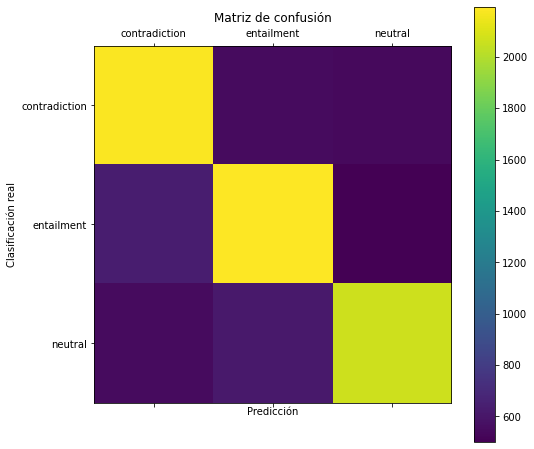

In [ ]:
predict = clf.predict(cv_valid) 
clasificacion_real = labels_valid

matriz_conf = confusion_matrix(clasificacion_real, predict)
print(matriz_conf)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
cax = ax.matshow(matriz_conf)
plt.title('Matriz de confusión')
fig.colorbar(cax)
labels = ['contradiction','entailment','neutral']
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicción')
plt.ylabel('Clasificación real')
plt.show()

Las conclusiones generales del trabajo se encuentran detalladas en la parte dos correspondiente al modelo MLP.